<a href="https://colab.research.google.com/github/sohumgautam17/Cell_Seg_Count-CMU/blob/main/CMU_CSegNET_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/sohumgautam17/Cell_Seg_Count-CMU.git

Cloning into 'Cell_Seg_Count-CMU'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 108 (delta 35), reused 3 (delta 1), pack-reused 0
Receiving objects: 100% (108/108), 108.03 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (66/66), done.


In [3]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [4]:
import torch
import sklearn
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import requests
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from torch import nn
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from tqdm.auto import tqdm

In [5]:
!pwd  # Print current directory
!ls   # List contents of current directory

# Check current directory and change it if needed
if not "$(pwd)" == "/content/Cell_Seg_Count-CMU":
    %cd Cell_Seg_Count-CMU

/content
Cell_Seg_Count-CMU  sample_data
/content/Cell_Seg_Count-CMU


In [6]:
ls

 Annotations/                 process_data.py   read_xml.py            'Tissue Images'/
 CMU_CSegNET_Pipeline.ipynb   README.md         Segmentation_Model.py  'UNET Model'


#Downloading/Parse the Data and Inspect


In [7]:
from process_data import he_to_binary_mask

files_path = "./Tissue Images"
filename = []

for each_file in os.listdir(files_path):
  each_file = each_file[:-4]
  filename.append(each_file)

print(filename[:5])


30
30


Processing: 100%|██████████| 30/30 [01:54<00:00,  3.82s/it]


['TCGA-DK-A2I6-01A-01-TS1', 'TCGA-RD-A8N9-01A-01-TS1', 'TCGA-G9-6348-01Z-00-DX1', 'TCGA-HE-7130-01Z-00-DX1', 'TCGA-AR-A1AS-01Z-00-DX1']


In [33]:
## testing with 2 files
filename = filename[:2]
orig_binmask_colormask = []
for i in filename:
  orig_binmask_colormask.append(he_to_binary_mask(i))

In [34]:
###EXAMPLE VISUALIZATIONS...
image = 2
orig = orig_binmask_colormask[image-1]['original_image']
binary_mask = orig_binmask_colormask[image-1]["binary_mask"]
color_mask = orig_binmask_colormask[image-1]['color_mask']

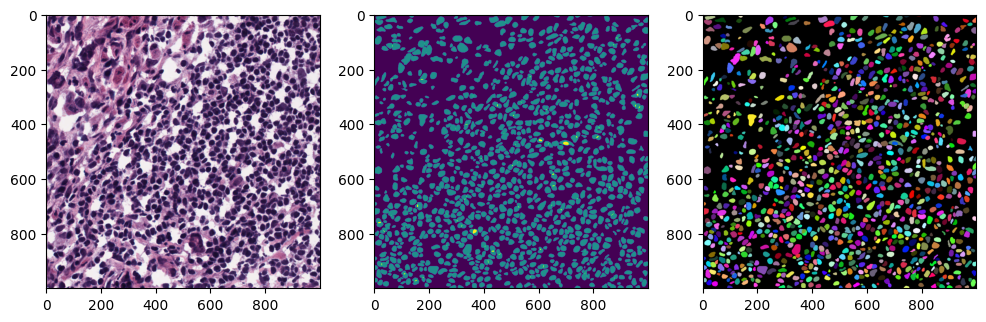

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(orig)
axes[1].imshow(binary_mask)
axes[2].imshow(color_mask)

plt.show()

In [36]:
len(orig_binmask_colormask[1])

3

In [37]:
orig_binmask_colormask

[{'original_image': array([[[ 54,  23,  64],
          [ 54,  23,  62],
          [ 54,  23,  61],
          ...,
          [100,  47, 113],
          [104,  48, 119],
          [110,  49, 121]],
  
         [[ 51,  23,  61],
          [ 51,  23,  59],
          [ 51,  23,  58],
          ...,
          [110,  47, 114],
          [120,  49, 119],
          [125,  51, 119]],
  
         [[ 49,  23,  59],
          [ 49,  23,  57],
          [ 49,  23,  57],
          ...,
          [135,  68, 117],
          [146,  72, 121],
          [147,  72, 117]],
  
         ...,
  
         [[ 80,  43,  96],
          [ 78,  40,  94],
          [ 76,  38,  92],
          ...,
          [169, 104, 149],
          [163, 101, 150],
          [149,  98, 149]],
  
         [[ 78,  43,  96],
          [ 76,  40,  95],
          [ 74,  38,  93],
          ...,
          [171, 106, 150],
          [161, 101, 149],
          [144,  97, 149]],
  
         [[ 74,  38,  98],
          [ 72,  38,  90],
      

In [38]:
X = [] # this will store all original images
y = [] # this will store all binary masked images, we can change this to color masks later, but for rn
for dictionary in orig_binmask_colormask:
  X.append(dictionary['original_image'])
  y.append(dictionary['binary_mask'])


In [39]:
X_tensor = torch.Tensor(numpy.array(X))
X_tensor = torch.permute(X_tensor, (0, 3, 1, 2))
y_tensor = torch.Tensor(numpy.array(y))

In [40]:
X_tensor.shape, y_tensor.shape

(torch.Size([2, 3, 1000, 1000]), torch.Size([2, 1000, 1000]))

#Setup Configs + Batching



In [41]:
EPOCHS = 5

BATCH_SIZE = 1
LR = 0.05
test_ratio = 0.3

ENCODER = 'timm-efficientnet-b7'
WEIGHTS = 'imagenet'

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_ratio, random_state=42)

In [43]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1, 1, 1, 1)

In [44]:
print(X_train.shape)
print(y_train.shape)

torch.Size([1, 3, 1000, 1000])
torch.Size([1, 1000, 1000])


In [45]:
train_set = TensorDataset(X_train,  y_train)
test_set = TensorDataset(X_test, y_test)

In [46]:
train_set

In [47]:
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [48]:
print(len(train_loader))
print(len(test_loader))


1
1


#Segmentation Model ... Temporary until the model file is built

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super().__init__()
    #self.pad = nn.ZeroPad2d((6, 6, 6, 6))
    self.architecture = smp.Unet(
      encoder_name=ENCODER,
      encoder_weights = WEIGHTS,
      in_channels = 3,
      classes=1
    )

  def forward(self, x):
    h, w = x.size()[-2:]
    pad_h = ((h // 32) + 1) * 32 - h
    pad_w = ((w // 32) + 1) * 32 - w
    # Apply padding
    x = nn.ZeroPad2d((0, pad_w, 0, pad_h))(x)
    return self.architecture(x)
    return self.architecture(x)

model_0 = SegmentationModel()
model_0

#Training Loop

In [50]:
loss_fn = DiceLoss(mode='binary')
#loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LR)

In [51]:
def train(model, optimizer):
  model.train()
  total_train_loss = 0
  for epoch in tqdm(range(EPOCHS)):
    for batch_idx, (image, annote) in enumerate(train_loader):
      print(f"Epoch #{epoch}...")
      logits = model(image)

      loss  = loss_fn(logits, annote)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_train_loss += loss

  return total_train_loss/EPOCHS

def eval(model:torch.nn.Module):
  model.eval()
  total_test_loss = 0
  with torch.inference_mode():
    for batch_idx, (image, annote) in test_loader:
      test_logits = model(image)

      loss = loss_fn(test_logits, annote)

      total_test_loss += loss

  return total_test_loss/EPOCHS




In [ ]:
train(model_0, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0...
